### 1. Crawling the information from website of stock news  http://www.aastocks.com/en/stocks/news/aafn-company-news as below and create news repository by extracting the information from the html content

In [8]:
import re
import requests
from lxml import etree
from bs4 import BeautifulSoup
import time
from urllib.parse import urljoin
import json

import pandas as pd
#pd.set_option('display.max_columns', None)
import numpy as np
import numexpr as ne

#!pip install selenium
#!apt-get update # to update ubuntu to correctly run apt install
#!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

#webdriver.Chrome().browser. find_elements(By.CLASS_NAME,'inline_block') all '%inline_block%' bars <div class="inline_block lastupdsep"><div>/ (By.CSS_SELECTOR,'p.inline_block')all exact bars <p class="inline_block">/ (By.PARTIAL_LINK_TEXT,'')
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [4]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
browser = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
#browser.get("http://music.163.com") 
#print(browser.page_source)
# browser.get(url)
# time.sleep(3)

#browser.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: use options instead of chrome_options
  """


**Headline | Releasing time | Polarity**

In [67]:
url = "http://www.aastocks.com/en/stocks/news/aafn-company-news"
headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
    "Referer": "http://www.aastocks.com/en/stocks/news/aafn/latest-news/0"
}
# How many times scrolls to bottum is required in initial url?
times = 1 

#def scrape(url, times): #def scrapeWeeklyCompNews(url, times):

if not url.startswith('http'):
    raise Exception('URLs need to start with "http"')

browser = webdriver.Chrome('chromedriver',options=chrome_options)
print('Hi, I will be digging so hard for a while, Please take a break or have a cup of tea ;)')
browser.get(url)
time.sleep(2)  # Allow 2 seconds for the web page to open
scroll_pause_time = 5 # load all weekly news (15 pages) # You can set your own pause time. My laptop is a bit slow so I use 1 sec
#screen_height = browser.execute_script("return window.screen.height;")   # get the screen height of the web
previous_height = browser.execute_script("return document.body.scrollHeight;")  # starting height
counter = 1

while True: # load all info in initial page
    # scroll one screen height each time
    browser.execute_script("window.scrollTo(0, {previous_height}*{i});".format(previous_height=previous_height, i=counter))
    #html = browser.find_element_by_tag_name('html') # Or direct send key
    #html.send_keys(Keys.END)   
    time.sleep(scroll_pause_time) # load all weekly news (15 pages)

    # whens.extend(t.text for t in list(browser.find_elements(By.CSS_SELECTOR,'div.inline_block')) if len(t.text)==16)
    # print(len(whens),'whens inserted: [..,"'+whens[-1]+'"],',counter,'pages done')
    counter += 1

    # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
    # scroll_height = browser.execute_script("return document.body.scrollHeight;")  
    # Break the loop when the height we need to scroll to is larger than the total scroll height
    if counter > times:  #if (screen_height) * i > scroll_height:
      break 

## get ['Releasing time'], ['Polarity']   
# after loading all documents..
whens = [tve.text for i,tve in enumerate(browser.find_elements(By.CSS_SELECTOR,'div.inline_block')) if len(tve.text)==16]
print(len(whens),'whens inserted: [..,"'+whens[-1]+'"],',counter-1,'pages done')
pos = [] # pos = [int(tve.text.replace('Positive','')) for i,tve in enumerate(browser.find_elements(By.CLASS_NAME,'divBullish'))]# if i%2 == 0]# even i for Bullish ,odd i for Bearish
neg = [] # neg = [int(tve.text.replace('Negative','')) for i,tve in enumerate(browser.find_elements(By.CLASS_NAME,'divBearish'))]# if i%2 != 0]# even i for Bullish ,odd i for Bearish
#VE = list(set(pos)-set(neg))  # VE = eval(tve.find_all(class_='value')[1].text+'-'+tve.find_all(class_='value')[2].text)
Polarity = []
for tve in list(browser.find_elements(By.CLASS_NAME,'div_VoteTotal')): # even i divBullish ,odd i for Bearish

  Bullish = int(tve.text.split('tive')[1].replace('Nega',''))
  Bearish = int(tve.text.split('tive')[2])
  VE = Bullish-Bearish

  pos.append(Bullish)
  neg.append(Bearish)
  Polarity.append('positive' if VE > 0 else 'negative' if VE < 0 else 'neutural')
print(len(Polarity),'Polarity inserted: [..,"'+Polarity[-1]+'"],',counter-1,'pages done')

## get ['Headline'] & news follow links
headlines = [] #headlines = [h.text for h in list(browser.find_elements(By.CLASS_NAME,'newshead4'))]
links = []
for h in list(browser.find_elements(By.XPATH,"//div[contains(@class, 'newshead4')]/a")):
  headlines.append(h.text)
  links.append(h.get_attribute('href'))
print(len(headlines),'headlines inserted: [..,"'+headlines[-1]+'"],',counter-1,'pages done')
print(len(links),'links inserted: [..,"'+links[-1]+'"],',counter-1,'pages done')
print('Thank you for your patience :)')

# if __name__ == '__main__':
#     scrape(url, 1) # How many times scrolls to bottum is required in initial url?

Hi, I will be digging so hard for a while, Please take a break or have a cup of tea ;)
300 links inserted: [..,"http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1189660/company-news/HK6"], 1 pages done
Thank you for your patience :)


In [69]:
browser.close() # close initial page

In [68]:
links # check validity for next scrape

['http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191473/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191470/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191461/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191454/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191456/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191431/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191420/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191423/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191414/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191408/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191407/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191399/company-news/HK6',
 'http://www.aastocks.com/en

In [54]:
# concat all columns
df = pd.DataFrame({'Headline':headlines, 'Releasing time':whens, 'Polarity':Polarity})
df = df.convert_dtypes()
df

,Headline,Releasing time,Polarity
0,PBOC Reportedly Accepts Ant's Application to F...,2022/06/17 19:05,positive
1,HKD336.4M Southbound Trading Net Inflow to GCL...,2022/06/17 18:25,positive
2,CKA: Harbour Plaza Resort City Hotel Rooms Con...,2022/06/17 17:39,positive
3,PARKnSHOP: 1Q Turnover Posts Double-digit Grow...,2022/06/17 17:14,positive
4,"ByteDance Disbands 101 Studio, Sacks About 150...",2022/06/17 17:12,positive
...,...,...,...
295,<Resumption Ann>CHINA JINMAO Proposes Privatiz...,2022/06/10 08:20,positive
296,Alibaba’s Shr Price Plunges over 8%; Ant: Focu...,2022/06/10 08:15,positive
297,<US Stocks>DJIA Craters 638 pts or 1.9%; Aliba...,2022/06/10 08:12,positive
298,BILIBILI-SW: Covid Not to Hurt Long-term Funda...,2022/06/10 07:30,negative


In [55]:
df['Headline'] 

0      PBOC Reportedly Accepts Ant's Application to F...
1      HKD336.4M Southbound Trading Net Inflow to GCL...
2      CKA: Harbour Plaza Resort City Hotel Rooms Con...
3      PARKnSHOP: 1Q Turnover Posts Double-digit Grow...
4      ByteDance Disbands 101 Studio, Sacks About 150...
                             ...                        
295    <Resumption Ann>CHINA JINMAO Proposes Privatiz...
296    Alibaba’s Shr Price Plunges over 8%; Ant: Focu...
297    <US Stocks>DJIA Craters 638 pts or 1.9%; Aliba...
298    BILIBILI-SW: Covid Not to Hurt Long-term Funda...
299    CBIRC: Large State-owned Banks Required to Ens...
Name: Headline, Length: 300, dtype: string

**Company name | Stock Code | Abstract** (loading and retreive requiering ~10+time.sleep(2) second per news, using links extracted from above)

In [74]:
fol_headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
    "Referer": "http://www.aastocks.com/en/stocks/news/aafn-company-news"
    }
symbols = []
names = []
abstracts = []
browser = webdriver.Chrome('chromedriver',options=chrome_options)
print('Hi, I will be digging so hard for a while, Please take a break or have a cup of tea ;)')
# 300 links requiring ~1hr (including 10 mins time.sleep), ~12 sec/link to retrieve [name], [symbol] & [abstract]
for link in links: # follow each news links to get [name], [symbol] & [abstract]
  #wait = WebDriverWait(browser, scroll_pause_time) # we don't want scroll initial page again https://stackoverflow.com/questions/70683534/python-selenium-iterate-table-of-links-clicking-each-link
  print(link)
  browser.get(link)
  print('Loading 2 sec to pretend as a human..')
  time.sleep(2)
  abstracts.append(browser.find_element(By.XPATH,'//p').text)
  print(len(abstracts),'abstracts inserted')
  #sym = browser.execute_script('return NewsRelativeSymbol') # str[:5]
  # sess = requests.session()
  # response = sess.get(link, headers=fol_headers)
  # soup = BeautifulSoup(response.json(),'lxml') #.content html.parser
  #abstract.append(soup.find("p").text) #.get_text(strip=True,separator='<br>').split('<br>')#.text.strip().split('\n')[0]#.strip()#.contents.strip()#class_= 'newscontent5 fLevel3')
  #sym = soup.find("a",class_='jsStock jsBmpStock').get('sym')
  try:
  #   sym = soup.find("a",class_='jsStock jsBmpStock')['sym']
    button = browser.find_element(By.XPATH,'//a[@class="jsStock jsBmpStock"]')#.get_attribute('href') # 1st relevant symbol appears
    
  except Exception as e:
    print(e,'\nNo Ticker button appears, getting Related Symbol')
    # json_string = re.search(r'NewsRelativeSymbol\s*=\s*(.*)', str(soup.find('script')), flags=re.DOTALL)
    # #sym = soup.find('a',class_='more-lnk') 
    # sym = json.loads(json_string[1])
    # above return empty...
    button = browser.find_element(By.LINK_TEXT,"Related News") # related symbol from related news link

  browser.execute_script("arguments[0].click();", button)
  symbols.append(browser.find_element(By.XPATH,'//div[@id="SQ_Symbol"]').text[1:6])
  print(len(symbols),'symbols inserted: [..,"'+symbols[-1]+'"],')
  names.append(browser.find_element(By.XPATH,'//label[@id="SQ_Name"]').text)
  print(len(names),'company names inserted: [..,"'+names[-1]+'"]')


print('Thank you for your patience :)')

Hi, I will be digging so hard for a while, Please take a break or have a cup of tea ;)
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191473/company-news/HK6
Loading 2 sec to pretend as a human..
1 abstracts inserted
1 symbols inserted: [..,"09988"],
1  company names inserted: [..,"BABA-SW"]
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191470/company-news/HK6
Loading 2 sec to pretend as a human..
2 abstracts inserted
2 symbols inserted: [..,"03800"],
2  company names inserted: [..,"GCL TECH"]
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191461/company-news/HK6
Loading 2 sec to pretend as a human..
3 abstracts inserted
3 symbols inserted: [..,"01113"],
3  company names inserted: [..,"CK ASSET"]
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191454/company-news/HK6
Loading 2 sec to pretend as a human..
4 abstracts inserted
4 symbols inserted: [..,"00001"],
4  company names inserted: [..,"CKH HOLDINGS"]
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.119145

In [97]:
browser.close()

In [ ]:
# after finish digging..
df['Company name'] = names
df['Stock Code'] = symbols
df['Abstract'] = abstracts

**Headline | Releasing time | Company name | Stock Code | Abstract | Polarity**

In [104]:
df = df[['Headline', 'Releasing time', 'Company name', 'Stock Code', 'Abstract','Polarity']]
df = df.convert_dtypes()
df['Releasing time'] = pd.to_datetime(df['Releasing time'])
df['Stock Code'] = df['Stock Code'].astype('category')
df['Polarity'] = df['Polarity'].astype('category')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Headline        300 non-null    string        
 1   Releasing time  300 non-null    datetime64[ns]
 2   Company name    300 non-null    string        
 3   Stock Code      300 non-null    category      
 4   Abstract        300 non-null    string        
 5   Polarity        300 non-null    category      
dtypes: category(2), datetime64[ns](1), string(3)
memory usage: 15.2 KB


,Headline,Releasing time,Company name,Stock Code,Abstract,Polarity
0,PBOC Reportedly Accepts Ant's Application to F...,2022-06-17 19:05:00,BABA-SW,09988,The People's Bank of China (PBOC) has accepted...,positive
1,HKD336.4M Southbound Trading Net Inflow to GCL...,2022-06-17 18:25:00,GCL TECH,03800,"There was HKD336.4 million, HKD297.1 million a...",positive
2,CKA: Harbour Plaza Resort City Hotel Rooms Con...,2022-06-17 17:39:00,CK ASSET,01113,CK ASSET (01113.HK) -0.500 (-0.967%) Short...,positive
3,PARKnSHOP: 1Q Turnover Posts Double-digit Grow...,2022-06-17 17:14:00,CKH HOLDINGS,00001,"Norman Yum, Managing Director of PARKnSHOP Sup...",positive
4,"ByteDance Disbands 101 Studio, Sacks About 150...",2022-06-17 17:12:00,TENCENT,00700,"ByteDance disbanded its ""101 Studio"" gaming op...",positive
...,...,...,...,...,...,...
295,<Resumption Ann>CHINA JINMAO Proposes Privatiz...,2022-06-10 08:20:00,CHINA VAST,06166,CHINA VAST (06166.HK) 0.000 (0.000%) receiv...,positive
296,Alibaba’s Shr Price Plunges over 8%; Ant: Focu...,2022-06-10 08:15:00,BABA-SW,09988,Alibaba Group Holding (BABA.US) ’s share pr...,positive
297,<US Stocks>DJIA Craters 638 pts or 1.9%; Aliba...,2022-06-10 08:12:00,BABA-SW,09988,U.S. stocks declined as investors turned incre...,positive
298,BILIBILI-SW: Covid Not to Hurt Long-term Funda...,2022-06-10 07:30:00,BILIBILI-SW,09626,The first-quarter results of BILIBILI-SW (0962...,negative


In [106]:
df.to_excel('/content/drive/MyDrive/ML_skillset/AAstocksWEEKLYcompNews.xlsx', index=True, header = df.columns) # excel can fixed grid size

In [ ]:
# lst.append -> df[''].extend()

### *Scraping draft, Please skip*

In [ ]:
# Xpath format
cast = [item.strip() for item in root.xpath("//*[contains(@class,'cast-item')]//a/span[@title]/text()")] 

In [ ]:
response.status_code #状态码:200=成功
#response.encoding 	#查看响应头部字符编码
#response.cookies 	#cookie信息

200

In [ ]:
response.headers 	#头信息

{'Cache-Control': 'no-cache', 'Pragma': 'no-cache', 'Content-Type': 'text/html; charset=utf-8', 'Expires': '-1', 'X-Frame-Options': 'SAMEORIGIN', 'Date': 'Wed, 15 Jun 2022 05:56:41 GMT', 'Age': '33        ', 'Via': 'AX-CACHE-4.1:129', 'Transfer-Encoding': 'chunked', 'Content-Encoding': 'gzip', 'Vary': 'Accept-encoding', 'Set-Cookie': 'aa_cookie=83.137.158.13_42121_1655269499; Domain= .aastocks.com; Path=/'}

In [ ]:
#response.json() #JSON形式的响应内容(其实就是dict字典类型)
#response.text 	#文本形式的响应内容
#response.content #二进制字节形式的响应内容

'\r<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd"> <html xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#"> <head id="Head1"><meta http-equiv="X-UA-Compatible" content="IE=Edge" /><meta name="google-site-verification" content="PSvX40cckR7V_q8QVaRk5jnTEIeinakRTyMqcjv9WPI" /> <script type="text/javascript">\rvar _gaq = _gaq || [];\r_gaq.push([\'_setAccount\', \'UA-20790503-3\']);\r_gaq.push([\'_setDomainName\', \'www.aastocks.com\']);\r_gaq.push([\'_setSampleRate\', \'5\']);\r_gaq.push([\'_trackPageview\']);\r_gaq.push([\'_trackPageLoadTime\']);\r_gaq.push([\'a3._setAccount\', \'UA-130882905-1\']);\r_gaq.push([\'a3._setDomainName\', \'www.aastocks.com\']);\r_gaq.push([\'a3._trackPageview\']);\r_gaq.push([\'a3._trackPageLoadTime\']);\r_gaq.push([\'vt._setAccount\', \'UA-131025525-1\']);\r_gaq.push([\'vt._setDomainName\', \'www.aastocks.com\']);\rfunction O

In [ ]:
#browser.find_element_by_id('aafn-search-c1').text.split('\n')
#.find_elements_by_xpath('//div[@class="newshead4"]')
#browser.find_elements_by_xpath('//div[@class="newshead4"]')
# headlines = [h.text for h in browser.find_elements_by_xpath('//div[@class="newshead4"]')]# if 'NOW' in element]
# headlines

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  """Entry point for launching an IPython kernel.


['HKD344.5M Southbound Trading Net Inflow to CNOOC',
 '2022/06/16 18:25 Recommend0Positive0Negative0',
 'There was HKD344.5 million and HKD236 million Southbound Trading net inflow to CNOOC (00883.HK) and KUAISHOU-W (01024.HK).There was HKD159.4 million, HKD93.4 million and HKD46 million Southbound Trading net outflow from KOOLEARN (01797.HK), CHINA SHENHUA (01088.HK) and MEITUAN-W (03690.HK).For Southbound Trading of Shanghai-Hong...',
 'CONCH CEMENT Proposes Issue of Max. RMB10B Medium-term Notes',
 '2022/06/16 17:49 Recommend0Positive0Negative1',
 'CONCH CEMENT (00914.HK) announced that it proposed the issue of medium-term notes of an aggregate principal amount of not more than RMB10 billion with the maturity of not more than 5 years. The proceeds to be raised from the issue of the Notes will mainly be applied to replenish the Company’s working capital, repay interes...',
 "HAOXIANGNI: 'MISS YOU' Brand Ties up with KOOLEARN's 'Dongfang Zhenxuan'",
 '2022/06/16 17:06 Recommend8Positi

In [ ]:
#browser.find_elements_by_xpath('//div[@class="newstime4"]')
#list(browser.find_elements_by_class_name('newshead4'))[0].text
#headlines = [h.text for h in browser.find_elements_by_xpath('//div[@class="newshead4"]')]
# what = [list(tve) for i,tve in enumerate(browser.find_elements(By.CSS_SELECTOR,'div.inline_block')) if i%2 == 0]
# what
#list(browser.find_elements(By.XPATH,'//div[@class="newstime4"]'))[0].text
#list(browser.find_elements(By.CLASS_NAME,'inline_block'))[0].text
# what = [int(tve.text.split('tive')[1].replace('Nega','')) for i,tve in enumerate(browser.find_elements(By.CLASS_NAME,'divBullish'))]# if i%2 == 0]# even i divBullish for ,odd i for Bearish
# what
# what = [tve for tve in list(browser.find_elements(By.XPATH,'//a[@class="href"]'))]# if i%2 == 0]# even i divBullish for ,odd i for Bearish
# what
base = 'http://www.aastocks.com/'
#browser.find_elements(By.PARTIAL_LINK_TEXT,'/en/stocks/news/aafn-con/NOW.')#.get_attribute('href').text
#browser.find_elements(By.XPATH,"//a[contains(@id, 'cp_ucAAFNSearch_repNews_lnkNews_')]")[0].get_attribute('href')
#browser.find_elements(By.XPATH,"//a[contains(@id, 'cp_ucAAFNSearch_repNews_lnkNews_')]")[0].get_attribute('title')
headlines = []
links = []
for h in list(browser.find_elements(By.XPATH,"//a[contains(@id, 'cp_ucAAFNSearch_repNews_lnkNews_')]")):
  headlines.append(h.get_attribute('title'))
  links.append(h.get_attribute('href'))
links

['http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191473/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191470/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191461/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191454/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191456/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191431/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191420/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191423/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191414/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191408/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191407/company-news/HK6',
 'http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191399/company-news/HK6',
 'http://www.aastocks.com/en

In [ ]:

fol_headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
    "Referer": "http://www.aastocks.com/en/stocks/news/aafn-company-news"
    }
symbols = []
names = []
abstract = []
browser = webdriver.Chrome('chromedriver',options=chrome_options)
for link in links: # follow each news links to get [name], [symbol] & [abstract]
  #wait = WebDriverWait(browser, scroll_pause_time) # we don't want scroll initial page again https://stackoverflow.com/questions/70683534/python-selenium-iterate-table-of-links-clicking-each-link
  print(link)
  browser.get(link)
  time.sleep(2)
  abstract.append(browser.find_element(By.XPATH,'//p').text)
  #sym = browser.execute_script('return NewsRelativeSymbol') # str[:5]
  # sess = requests.session()
  # response = sess.get(link, headers=fol_headers)
  # soup = BeautifulSoup(response.json(),'lxml') #.content html.parser
  #abstract.append(soup.find("p").text) #.get_text(strip=True,separator='<br>').split('<br>')#.text.strip().split('\n')[0]#.strip()#.contents.strip()#class_= 'newscontent5 fLevel3')
  #sym = soup.find("a",class_='jsStock jsBmpStock').get('sym')
  try:
  #   sym = soup.find("a",class_='jsStock jsBmpStock')['sym']
    button = browser.find_element(By.XPATH,'//a[@class="jsStock jsBmpStock"]')#.get_attribute('href') # 1st relevant symbol appears
    
  except Exception as e:
    print(e)
    # json_string = re.search(r'NewsRelativeSymbol\s*=\s*(.*)', str(soup.find('script')), flags=re.DOTALL)
    # #sym = soup.find('a',class_='more-lnk') 
    # sym = json.loads(json_string[1])
    # above return empty...
    button = browser.find_element(By.LINK_TEXT,"Related News") # related symbol from related news link

  browser.execute_script("arguments[0].click();", button)
  symbols.append(browser.find_element(By.XPATH,'//label[@id="SQ_Name"]'))
  names.append(browser.find_element(By.XPATH,'//div[@id="SQ_Symbol"]').text[1:6])

browser.close()
print(names)
print(symbols)

#abstract


http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191473/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191470/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191461/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191454/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191456/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191431/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191420/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191423/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191414/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191408/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191407/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191399/company-news/HK6
http://www.aastocks.com/en/stocks/news/aafn-con/NOW.1191397/company-news/HK6

In [ ]:
whens = []
Polarity = []
for i, tve in enumerate(browser.find_elements(By.XPATH,'//div[@class="newstime4"]')):
  if i%2 == 0: # 0,2,4
    whens.append(list(tve)[1].text.strip()) 
    VE = eval(tve.find_elements(By.CLASS_NAME,'value')[1].text+'-'+tve.find_elements(By.CLASS_NAME,'value')[2].text)
    Polarity.append('positive' if VE > 0 else 'negative' if VE < 0 else 'neutural')
print(whens)
print(Polarity)

TypeError: ignored

In [ ]:
##### Web scrapper for infinite scrolling page #####
driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
driver.get("https://www.reddit.com/search/?q=r%2FCOVID19")
time.sleep(3)  # Allow 2 seconds for the web page to open
scroll_pause_time = 3 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
#previous_height = driver.execute_script("return document.body.scrollHeight;")  # starting height
i = 1

while True:
    # scroll one screen height each time
    driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
    i += 1
    time.sleep(scroll_pause_time)
    # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
    scroll_height = driver.execute_script("return document.body.scrollHeight;")  
    # Break the loop when the height we need to scroll to is larger than the total scroll height
    if (screen_height) * i > scroll_height:
        break 

##### Extract Reddit URLs #####
urls = []
soup = BeautifulSoup(driver.page_source, "html.parser")
for parent in soup.find_all(class_="y8HYJ-y_lTUHkQIc1mdCq _2INHSNB8V5eaWp4P0rY_mE"):
    a_tag = parent.find("a", class_="SQnoC3ObvgnGjWt90zD9Z _2INHSNB8V5eaWp4P0rY_mE")
    base = "https://www.reddit.com/search/?q=covid19"
    link = a_tag.attrs['href']
    url = urljoin(base, link)
    urls.append(url)

**Headline | Releasing time | Polarity**

In [ ]:
#soup.find_all(class_="newstime4")
headlinesbs4 = [h.text for h in soup.find_all(class_="newshead4")]# if 'NOW' in element]
headlinesbs4
headlines = [h.text for h in list(browser.find_elements(By.CLASS_NAME,'newshead4'))]
headlines
whens = [tve.text for i,tve in enumerate(browser.find_elements(By.CSS_SELECTOR,'div.inline_block')) if len(tve.text)==16]#i in [_:-17] #and i%2 == 0]

[' Stanchart HK Maintains Best Lending Rate at 5.25% ',
 ' <IPO News>Baba-backed GOGOX (02246.HK) Said to be Over-subscribed ',
 ' BONJOUR HOLD Halts Shr Trading PM, Pending Reasons ',
 ' <Midday Takeaway>Top 5 Gainers among ETFs; FL2CAMNDQ100 (07261.HK) Surges 4.5% Topping Chart ',
 ' HSBC Keeps Best Lending Rate at 5% ',
 ' JD Boosts Efficiency, Cuts Logistics Cost by Smart Operation, Optimized Warehouse Network  ',
 " Tencent QQ Unrolls 'Smart Video Subtitles', Only Supports Mandarin Chinese on Android Phones  ",
 ' JD, KUAISHOU Shr Trends Mixed; Beijing Proposes Supports for Key e-Commerce Platforms  ',
 ' CN WeChat Pay Appears to Encounter System Abnormality: Report  ',
 ' <Research Report>HSBC Global Research Foresees CN to Launch More Stimulus for Property Demand; COLI, CRL, CIFI Preferred ',
 ' Tencent In-house Biz Completes Full Cloud Migration ',
 " China Securities: KOOLEARN 'Dongfang Zhenxuan' Channel Woos Over 1M Fans Daily; Fans Size May Hit 20M in Future ",
 ' <Research 

In [ ]:
whensbs4 = []
Polaritybs4 = []
for i, tve in enumerate(soup.find_all(class_="newstime4")):
  if i%2 == 0: # 0,2,4
    whens.append(list(tve)[1].text.strip()) 
    VE = eval(tve.find_all(class_='value')[1].text+'-'+tve.find_all(class_='value')[2].text)
    Polarity.append('positive' if VE > 0 else 'negative' if VE < 0 else 'neutural')
print(whensbs4)
print(Polaritybs4)

['2022/06/15 18:25', '2022/06/15 17:40', '2022/06/15 17:38', '2022/06/15 17:12', '2022/06/15 16:42', '2022/06/15 16:30', '2022/06/15 16:27', '2022/06/15 16:00', '2022/06/15 15:58', '2022/06/15 15:46', '2022/06/15 15:39', '2022/06/15 14:57', '2022/06/15 14:40', '2022/06/15 14:34', '2022/06/15 14:29', '2022/06/15 13:06', '2022/06/15 12:38', '2022/06/15 12:30', '2022/06/15 12:09', '2022/06/15 12:04']
['positive', 'positive', 'positive', 'negative', 'positive', 'neutural', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']


In [ ]:
pos = [] # pos = [int(tve.text.replace('Positive','')) for i,tve in enumerate(browser.find_elements(By.CLASS_NAME,'divBullish'))]# if i%2 == 0]# even i for Bullish ,odd i for Bearish
neg = [] # neg = [int(tve.text.replace('Negative','')) for i,tve in enumerate(browser.find_elements(By.CLASS_NAME,'divBearish'))]# if i%2 == 0]# even i for Bullish ,odd i for Bearish
#VE = list(set(pos)-set(neg))  # VE = eval(tve.find_all(class_='value')[1].text+'-'+tve.find_all(class_='value')[2].text)
Polarity = []
for tve in list(browser.find_elements(By.CLASS_NAME,'div_VoteTotal')): # even i divBullish ,odd i for Bearish

  Bullish = int(tve.text.split('tive')[1].replace('Nega',''))
  Bearish = int(tve.text.split('tive')[2])
  VE = Bullish-Bearish

  pos.append(Bullish)
  neg.append(Bearish)
  Polarity.append('positive' if VE > 0 else 'negative' if VE < 0 else 'neutural')

print(pos)
print(neg)
print(Polarity)


[0, 0, 16, 23, 3, 7, 3, 3, 57, 45, 49, 26, 16, 11, 66, 55, 45, 39, 14, 22]
[0, 1, 8, 9, 1, 4, 7, 1, 15, 17, 28, 10, 10, 3, 36, 19, 31, 15, 15, 13]
['neutural', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive']


In [ ]:
abstract = [h.text for h in soup.find_all(class_="newscontent4")]
abstract

['Standard Chartered Bank (Hong Kong) Limited announced that its Best Lending Rate remains unchanged at 5.25 percent per annum. There is also no change for its rates for the HKD savings accounts. ~AAStocks Financial NewsWeb Site: www.aastocks.com',
 "BABA-SW (09988.HK)-backed GOGOX (02246.HK) has recorded an over-subscription covering both public offering and greenshoe, according to market sources.GOGOX's IPO spans from Tuesday (14 June) to Friday (17 June), with listing slated for next Friday (24 June). Entry fee is about $4,343.35 with a board lot size of 200 shares. ~...",
 "Trading in the shares of BONJOUR HOLD (00653.HK) has been suspended at 1:00 p.m. today, pending announcement of the reasons.BONJOUR HOLD's stock price burgeoned 2.6% to $0.119 midday, with turnover of $97,586.~AAStocks Financial NewsWeb Site: www.aastocks.com",
 'FL2CAMNDQ100 (07261.HK) closed at HK$14.01,up 4.5%.FL2CSOPNASDAQ (07266.HK) closed at HK$11.06,up 4.4%.CSOP CSI PV (03134.HK) closed at HK$9.89,up 3.9%

#### **Company name | Stock Code | Abstract**

In [ ]:
target = soup.find_all(class_='content')[9]
#target = '{' + target.replace(' ', '') + '}'
target

<div class="content comm-panel2"> <div class="ns1 white"> <div class="bg"></div> <div class="title"><a href="/en/stocks/news/aafn/popular-news">Hottest Topics <span class="smaller">(last 2 hours)</span></a></div> <a class="more-lnk" href="/en/stocks/news/aafn/popular-news" id="cp_ucTodayHot_lnkThm2More"></a> </div> <table class="ns1" style="width:100%;"> <tbody> <tr> <td> <div> <div class="ratio-circle r10"> <div class="num blue"><span class="tooltips-target">1</span></div> <div class="pct blue"><span class="tooltips-target">236</span></div> </div> <div class="news-headline"> <a href="/en/stocks/news/aafn-con/NOW.1190793/popular-news" title="&lt;Research Report&gt;JPM Ratings, TPs on Key CN Insurers (Table)">
&lt;Research Report&gt;JPM Ratings, TPs on Key CN Insurers (Table)</a></div> <div class="clear"></div> </div> </td> </tr> <tr> <td> <div> <div class="ratio-circle r6"> <div class="num blue"><span class="tooltips-target">2</span></div> <div class="pct blue"><span class="tooltips-ta

In [ ]:
target = [element for element in list(soup.body)]# if 'NOW' in element]
print(target)

}
});
.ind-box .ind-name { padding-top:2px }
var isEnableSearch = true;
</script> <style type="text/css">
.video-js { height:111px !important; width:100% !important; position: relative !important; }
.video-js .vjs-fullscreen-control { display:none; }
.video-container {position:relative; width:100%; display:inline-block; height:111px; }
.video-container video::-internal-media-controls-download-button {display:none;}
.video-container video::-webkit-media-controls-enclosure {overflow:hidden;}
.video-container video::-webkit-media-controls-panel {width: calc(100% + 30px);}
a.back { font-size:14px; }
.newstime2.RemarkEnOnly { position:absolute; right:0px; bottom:7px; font-size:13px; }
body.eng div.newsFilter .lnk2
,body.eng div.newsFilter .lnk2:visited
,body.eng div.newsFilter .lnk2:link { font-size:13px; }
#divNativeAd_Common { overflow: hidden; }
.lastupdsep { margin-left: 5px; width: 1px; height: 12px; background: #ccc; }
.div_VoteTotal { margin-left: 5px; }
.div_VoteTotal > div { font-s

### 2. Performing sentiment analysis using data extracted by using ML algorithms using traditional neural network and BERT by splitting the datasets into 80:20 for training datasets and validation datasets and export the model performance accuracy, recall and please compare neural network and BERT in terms of model performance and computation complexity.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import numexpr as ne #for array運算,比np快數十倍。str要评估的查询字符串。你可以在环境中引用变量，在它们前面添加一个'@'字符 。@a + b #eval若表达式为逻辑，结果返回bool数组;query则返回bool数组的数据


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_context('notebook') # talk/notebook/poster
sns.set_style('whitegrid') # whitegrid , ticks
sns.set_palette('bright') # with sns.color_palette(''): Qualitative:'bright' /hls husl Paired Set1~Set3（色调不同）; Sequential:'GnBu_d'/'BuGn_r' Blues[蓝s，颜色+s] BuGn[蓝绿] cubehelix; 特徵大min大max用Diverging: ('RdBu',7) BrBG[棕绿] RdBu[红蓝] coolwarm[冷暖]

#### **Statistical Analysis tools**

In [ ]:
import statsmodels.api as sm

!pip install --upgrade requests
!pip install folium==0.2.1
#!pip install --upgrade MarkupSafe
!pip install pandas_Profiling
!pip install markupsafe==2.1.1
#!pip install --upgrade pandas_Profiling
#!pip install -U --pre pycaret
!pip install pycaret
!pip install --user --upgrade aws-sam-cli
#!pip install --user aws-sam-cli
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

#### Splitting the datasets into 80:20 for training datasets and validation datasets

In [98]:
df

,Headline,Releasing time,Company name,Stock Code,Abstract,Polarity
0,PBOC Reportedly Accepts Ant's Application to F...,2022-06-17 19:05:00,BABA-SW,09988,The People's Bank of China (PBOC) has accepted...,positive
1,HKD336.4M Southbound Trading Net Inflow to GCL...,2022-06-17 18:25:00,GCL TECH,03800,"There was HKD336.4 million, HKD297.1 million a...",positive
2,CKA: Harbour Plaza Resort City Hotel Rooms Con...,2022-06-17 17:39:00,CK ASSET,01113,CK ASSET (01113.HK) -0.500 (-0.967%) Short...,positive
3,PARKnSHOP: 1Q Turnover Posts Double-digit Grow...,2022-06-17 17:14:00,CKH HOLDINGS,00001,"Norman Yum, Managing Director of PARKnSHOP Sup...",positive
4,"ByteDance Disbands 101 Studio, Sacks About 150...",2022-06-17 17:12:00,TENCENT,00700,"ByteDance disbanded its ""101 Studio"" gaming op...",positive
...,...,...,...,...,...,...
295,<Resumption Ann>CHINA JINMAO Proposes Privatiz...,2022-06-10 08:20:00,CHINA VAST,06166,CHINA VAST (06166.HK) 0.000 (0.000%) receiv...,positive
296,Alibaba’s Shr Price Plunges over 8%; Ant: Focu...,2022-06-10 08:15:00,BABA-SW,09988,Alibaba Group Holding (BABA.US) ’s share pr...,positive
297,<US Stocks>DJIA Craters 638 pts or 1.9%; Aliba...,2022-06-10 08:12:00,BABA-SW,09988,U.S. stocks declined as investors turned incre...,positive
298,BILIBILI-SW: Covid Not to Hurt Long-term Funda...,2022-06-10 07:30:00,BILIBILI-SW,09626,The first-quarter results of BILIBILI-SW (0962...,negative


#### Traditional neural network performance accuracy, recall and complexity (RNN) https://www.baeldung.com/cs/networks-in-nlp

#### BERT performance accuracy, recall and complexity

#### Compare Two models accuracy, recall and complexity

### 3. Plot the sentiment analysis results as below figure by using the prediction results of polarity of last 14 days news (number of negative, positive, neutral)
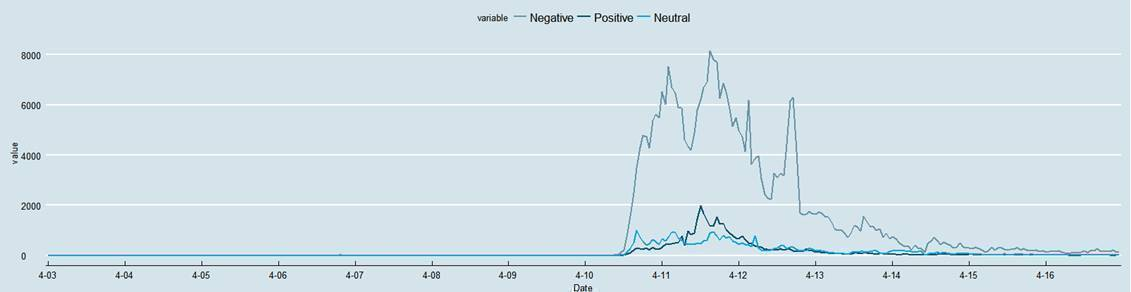